# A Volatility Model Study
An important issue at the market risk management is the volatility of the returns.
So we will study different models to estimate the volatility of the returns and compare their performance.
To backtest the models we will use the estimation of the value at risk (VaR) and the expected shortfall (ES) for different time horizons of the returns.

## Data
We will use the following assets: 
- ^GSPC: "S&P 500 Index",
- BTC-USD: "Bitcoin",
- CLP=X: "USD/CLP (Chilean Peso)",
- SQM: "SQM (Lithium Chile)",
- HG=F: "Copper Futures",
- TSLA: "Tesla Inc.",
- NVDA: "NVIDIA Corp.",
- CL=F: "Crude Oil WTI",
- TLT: "US Treasury Bond 20Y",
- VXX: "VIX Short-Term Futures"

## Models
We will study the following models:
- Historical Volatility
- Historical Normal Volatility
- GARCH
- DeepVol


In [1]:
import sys
import os

# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
import pandas as pd
import numpy as np
# import stats 
from scipy.stats import norm

import matplotlib.pyplot as plt
from src.models.historical import HistoricalVolModel
from src.models.historical_var import HistoricalVaRModel
from src.models.parametric_var import ParametricVaRModel
from src.evaluation.residuals import meucci_check

from data.market_data import MarketData # Assuming you have this helper

In [14]:

# 1. Load Data
# ticker = 'CLP=X'
ticker = 'SQM'



print(f"Loading data for {ticker}...")
market_data = MarketData(ticker, project_id='quant-ai-lab') # Use your existing loader
market_data.load_data()
df_data = market_data.data

Loading data for SQM...
Fetching data from BigQuery...
Downloading: 100%|██████████|


### Outliers
We replace the outliers with the value previous to the outlier. We define an outlier as a value that is more than 3.72 standard deviations away from the mean (3.72 is the 99.9% quantile of the standard normal distribution).

In [15]:
market_data.replace_outliers()

Outliers:
Series([], Name: price, dtype: float64)


In [16]:
# Ensure returns are calculated
df_data['log_ret'] = np.log(df_data['price'] / df_data['price'].shift(1))
df_data.dropna(inplace=True)


In [17]:
df_data.describe()

,price,log_ret
count,2733.000000,2733.000000
mean,37.616587,0.000526
std,19.841307,0.028845
min,8.255907,-0.205460
25%,22.254187,-0.015454
50%,36.369999,0.000310
75%,45.540001,0.016129
max,99.062477,0.188000


<Axes: title={'center': 'Historical Price SQM'}, xlabel='date'>

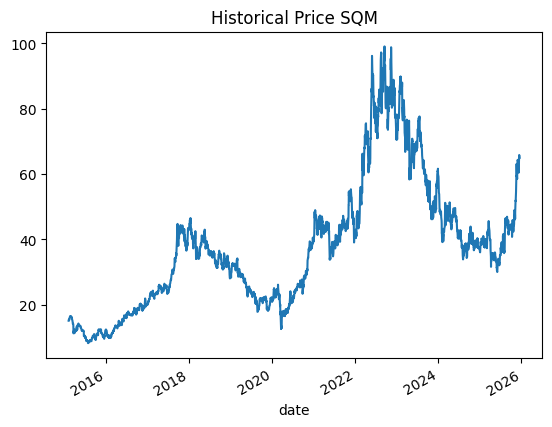

In [18]:
df_data['price'].plot(title=f"Historical Price {ticker}")

<Axes: title={'center': 'Historical Log Returns for SQM'}, xlabel='date'>

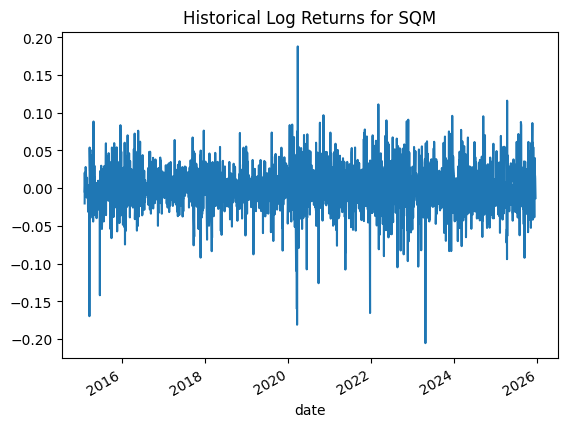

In [19]:
df_data['log_ret'].plot(title=f"Historical Log Returns for {ticker}")

In [20]:
invariant_check = meucci_check(df_data['log_ret'] - df_data['log_ret'].mean())


   MODEL DIAGNOSTIC REPORT (MEUCCI CHECK)
3. Independence (i.i.): Lag-1 Corr = 0.0117, Ljung-Box p = 0.4752
     lb_stat  lb_pvalue
10  9.611946   0.475172
   [PASS] Residuals look independent (White Noise).
4. Stability (i.d.): KS Test p-value = 0.0016
   [FAIL] Distribution changed in second half. Structural Break detected.



In [21]:
if invariant_check:
    print("  Market Invariants passed.")
else:
    print("  Market Invariants failed!!! Not recommended to use the Historical or Parametric VaR Models.")


  Market Invariants failed!!! Not recommended to use the Historical or Parametric VaR Models.


In [10]:
stop

NameError: name 'stop' is not defined

## Models

In [ ]:
models = []
alpha = 0.05

periods = {
    "Covid Crash (2020)": ('2020-01-01', '2020-06-30'),
    "Inflation Bear (2022)": ('2022-01-01', '2022-12-31'),
    "Volmageddon (2018)": ('2018-01-01', '2018-06-30'),
    "All (2020 - 2025)": ('2020-01-01', '2025-12-31')
}

### Historical VaR
We use a simple historical model to calculate the VaR for a given asset. That is one of the most basic models we can use to calculate VaR.

In [ ]:
windows = [22, 66, 126, 252]

for w in windows:
    model_name = f'Historical VaR {w}d'

    model = HistoricalVaRModel(market_data=market_data, model_name=model_name, window=w, alpha=alpha)
    model.results = {}
    for period_name, (start_date, end_date) in periods.items():
        df_data_test = market_data.data[(market_data.data.index >= start_date) & (market_data.data.index <= end_date)].copy()
        model.test(df_data_test)
        model.results[period_name] = float(model.data_test.outlier.sum() / len(model.data_test))

    models.append(model)

### Parametric VaR

In [ ]:
windows = [22, 66, 126, 252]

for w in windows:
    model_name = f'Parametric VaR {w}d'
    model = ParametricVaRModel(market_data=market_data, model_name=model_name, window=w, alpha=alpha)
    model.train()
    model.results = {}
    for period_name, (start_date, end_date) in periods.items():
        df_data_test = market_data.data[(market_data.data.index >= start_date) & (market_data.data.index <= end_date)].copy()
        model.test(df_data_test)
        model.results[period_name] = float(model.data_test.outlier.sum() / len(model.data_test))

    models.append(model)

In [ ]:
df_results = pd.DataFrame()
for model in models:
    for period_name in model.results:
        df_results.loc[model.model_name, period_name] = model.results[period_name]
df_results['mean'] = df_results.mean(axis=1)
df_results['std'] = df_results.std(axis=1)
np.round(df_results * 100, 2)


,Covid Crash (2020),Inflation Bear (2022),Volmageddon (2018),All (2020 - 2025),mean,std
Historical VaR 22d,8.46,8.85,6.92,8.32,8.14,0.73
Historical VaR 66d,6.15,6.15,3.85,6.38,5.63,1.04
Historical VaR 126d,6.15,7.31,1.54,5.74,5.18,2.18
Historical VaR 252d,9.23,9.23,1.54,5.29,6.32,3.20
Parametric VaR 22d,6.92,4.62,4.62,4.90,5.26,0.97
Parametric VaR 66d,7.69,2.69,3.08,4.90,4.59,1.98
Parametric VaR 126d,2.31,3.08,3.85,3.80,3.26,0.63
Parametric VaR 252d,7.69,5.00,4.62,3.87,5.29,1.44


In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:

alpha = 0.01
def backtest(df_full, periods, windows, alpha):     
    df_results = pd.DataFrame()
    for w in windows:
        for name, (start, end) in periods.items():
            # print(f"\n--- {name} ---")
            df_test = df_full[(df_full.index >= start) & (df_full.index <= end)].copy()
            for date in df_test.index:
                df_full_aux = df_full[(df_full.index < date)].tail(w)
                value_at_risk = float(df_full_aux.log_ret.quantile(alpha))
                df_test.loc[date, f'value_at_risk_{w}d'] = value_at_risk
            df_test[f'outlier_{w}d'] = 0
            df_test.loc[df_test.log_ret < df_test[f'value_at_risk_{w}d'], f'outlier_{w}d'] = 1
            df_results.loc[name, w] = df_test[f'outlier_{w}d'].sum() / len(df_test)
    return np.round(df_results, 2)
backtest(df_full, periods, windows, alpha)


,22,66,126,252
Covid Crash (2020),0.05,0.02,0.00,0.00
Inflation Bear (2022),0.05,0.02,0.03,0.03
Volmageddon (2018),0.04,0.01,0.01,0.01
Todo 2020 - 2025,0.05,0.02,0.02,0.01


### Historical Volatility Model
$$ VaR_{\alpha} = \mu + \sigma \cdot z_{\alpha} $$

In [ ]:
confidence = norm.ppf(alpha)
df_results = pd.DataFrame()
for w in windows:
    for name, (start, end) in periods.items():
        df_test = df_full[(df_full.index >= start) & (df_full.index <= end)].copy()
        for date in df_test.index:
            df_full_aux = df_full[(df_full.index < date)].tail(w)
            value_at_risk = float(df_full_aux.log_ret.mean() + confidence * df_full_aux.log_ret.std())
            df_test.loc[date, f'value_at_risk_{w}d'] = value_at_risk
        df_test[f'outlier_{w}d'] = 0
        df_test.loc[df_test.log_ret < df_test[f'value_at_risk_{w}d'], f'outlier_{w}d'] = 1
        df_results.loc[name, w] = df_test[f'outlier_{w}d'].sum() / len(df_test)
np.round(df_results, 2)


,22,66,126,252
Covid Crash (2020),0.04,0.01,0.00,0.00
Inflation Bear (2022),0.02,0.01,0.01,0.01
Volmageddon (2018),0.03,0.02,0.00,0.01
Todo 2020 - 2025,0.02,0.01,0.01,0.01


np.float64(-1.6448536269514729)

In [ ]:
import datetime as dt
import pytz
import pandas as pd
windows = [132]
alpha = 0.01

date_report = pd.Timestamp('2020-01-01', tz='UTC')

# date_report = dt.datetime(2020, 1, 1)

df_full['log_ret'] = df_full['log_ret'].astype(float)
w = windows[0]
# Create UTC-aware timestamp to match BigQuery data
date_report = pd.Timestamp('2020-01-01', tz='UTC')
date_report = pd.Timestamp('2020-01-01', tz='UTC')

df_aux = df_full[df_full.index <= date_report].tail(w)
value_at_risk = float(df_aux.log_ret.quantile(alpha))

# df_full['returns_{}d'.format(w)] = df_full['returns'].rolling(window=w).mean()

-0.028663496341709345


--- Diagnostic Report: HistVol_22d ---
1. Normality (JB): p=0.0000 | Kurtosis=5.31 (Target=0)
   [FAIL] Residuals are NOT Normal. Fat tails persist.
2. Independence (LB on z^2): p=0.0000
   [FAIL] Volatility clustering still present (Model is too slow).

--- Diagnostic Report: HistVol_66d ---
1. Normality (JB): p=0.0000 | Kurtosis=5.30 (Target=0)
   [FAIL] Residuals are NOT Normal. Fat tails persist.
2. Independence (LB on z^2): p=0.0000
   [FAIL] Volatility clustering still present (Model is too slow).

--- Diagnostic Report: HistVol_126d ---
1. Normality (JB): p=0.0000 | Kurtosis=7.41 (Target=0)
   [FAIL] Residuals are NOT Normal. Fat tails persist.
2. Independence (LB on z^2): p=0.0000
   [FAIL] Volatility clustering still present (Model is too slow).

--- Diagnostic Report: HistVol_252d ---
1. Normality (JB): p=0.0000 | Kurtosis=11.49 (Target=0)
   [FAIL] Residuals are NOT Normal. Fat tails persist.
2. Independence (LB on z^2): p=0.0000
   [FAIL] Volatility clustering still presen

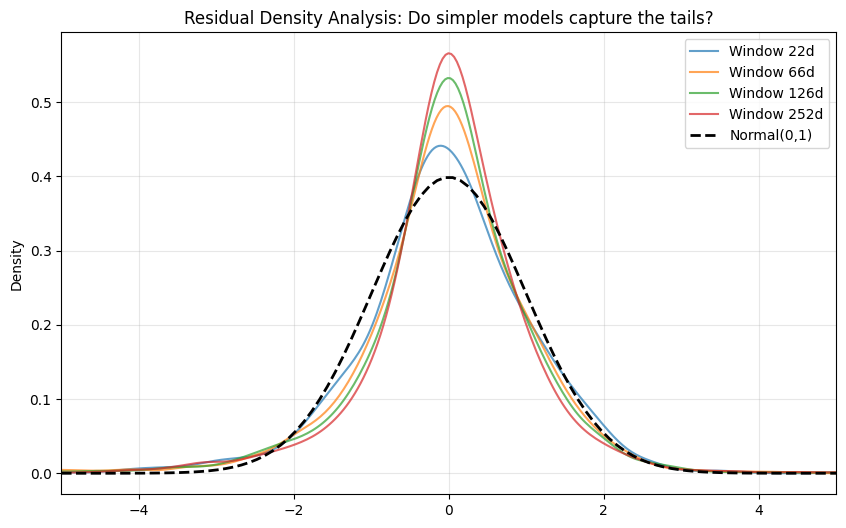

In [ ]:
# ---------------------------------------------------------
# PART A: RESIDUAL ANALYSIS (Which Window is "True"?)
# ---------------------------------------------------------
windows = [22, 66, 126, 252]
residuals_dict = {}

for w in windows:
    model = HistoricalVolModel(ticker, df_full, window=w)
    model.train()
    z = model.evaluate_residuals()
    residuals_dict[w] = z

# Visualization of Residual Distributions
plt.figure(figsize=(10, 6))
for w, z in residuals_dict.items():
    # Plot density
    z.plot(kind='kde', label=f'Window {w}d', alpha=0.7)

# Standard Normal Reference
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x), 'k--', linewidth=2, label='Normal(0,1)')

plt.title("Residual Density Analysis: Do simpler models capture the tails?")
plt.xlim(-5, 5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


>>> Analyzing Regime: Covid Crash (2020) (125 days)
   Window 22d: Breach Rate = 7.20% -> FAIL (Risk)
   Window 66d: Breach Rate = 8.80% -> FAIL (Risk)
   Window 126d: Breach Rate = 8.00% -> FAIL (Risk)
   Window 252d: Breach Rate = 11.20% -> FAIL (Risk)

>>> Analyzing Regime: Inflation Bear (2022) (251 days)
   Window 22d: Breach Rate = 1.99% -> OK
   Window 66d: Breach Rate = 3.19% -> FAIL (Risk)
   Window 126d: Breach Rate = 4.38% -> FAIL (Risk)
   Window 252d: Breach Rate = 5.98% -> FAIL (Risk)

>>> Analyzing Regime: Volmageddon (2018) (125 days)
   Window 22d: Breach Rate = 4.00% -> FAIL (Risk)
   Window 66d: Breach Rate = 4.00% -> FAIL (Risk)
   Window 126d: Breach Rate = 6.40% -> FAIL (Risk)
   Window 252d: Breach Rate = 7.20% -> FAIL (Risk)

=== SUMMARY: VaR Breach Rates (Target = 1.0%) ===
                           W_22      W_66    W_126      W_252
Regime                                                       
Covid Crash (2020)     7.200000  8.800000  8.00000  11.200000
Inf

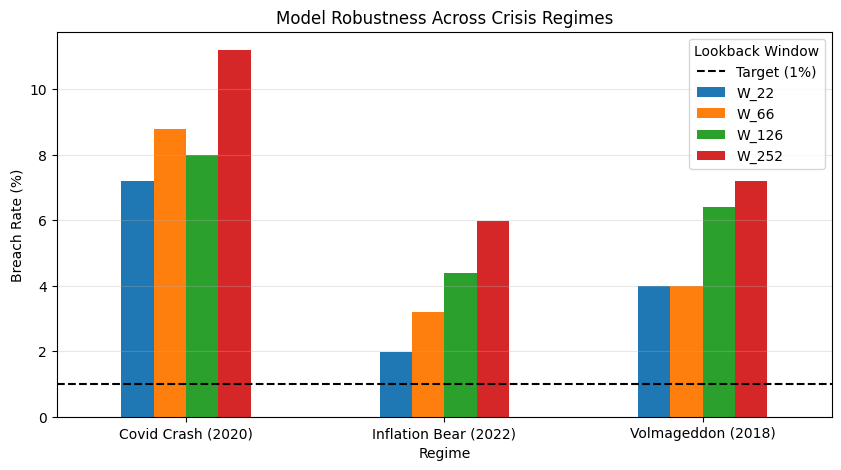

In [ ]:
# ---------------------------------------------------------
# PART B: REGIME-SPECIFIC BACKTESTING
# ---------------------------------------------------------
periods = {
    "Covid Crash (2020)": ('2020-01-01', '2020-06-30'),
    "Inflation Bear (2022)": ('2022-01-01', '2022-12-31'),
    "Volmageddon (2018)": ('2018-01-01', '2018-06-30')
}

portfolio_size = 1_000_000
confidence = 2.33 # 99%

# We will collect breach rates here
summary_data = []

for p_name, (start, end) in periods.items():
    # Slice Data
    df_period = df_full.loc[start:end].copy()
    
    print(f"\n>>> Analyzing Regime: {p_name} ({len(df_period)} days)")
    
    # Calculate PnL for this period
    actual_pnl = df_period['log_ret'] * portfolio_size
    losses = -actual_pnl # Positive value = Loss
    
    regime_results = {'Regime': p_name}
    
    for w in windows:
        # We need to compute the model on the full history to get the start of the period right,
        # then slice.
        model = HistoricalVolModel(ticker, df_full, window=w)
        model.train()
        
        # Get VaR for the specific period
        # Forecast (Annualized) -> Daily Sigma -> VaR
        sigma_pred_period = model.data.loc[start:end, 'sigma_pred']
        var_99 = sigma_pred_period * confidence * portfolio_size
        
        # Align with losses
        period_losses = losses.loc[sigma_pred_period.index]
        
        # Check Breaches
        breaches = period_losses > var_99
        breach_count = breaches.sum()
        breach_rate = (breach_count / len(period_losses)) * 100
        
        regime_results[f'W_{w}'] = breach_rate
        
        # Determine "Calibration" status
        status = "OK"
        if breach_rate > 2.0: status = "FAIL (Risk)"
        elif breach_rate < 0.5: status = "FAIL (Cost)"
        print(f"   Window {w}d: Breach Rate = {breach_rate:.2f}% -> {status}")

    summary_data.append(regime_results)

# ---------------------------------------------------------
# PART C: SUMMARY TABLE
# ---------------------------------------------------------
print("\n=== SUMMARY: VaR Breach Rates (Target = 1.0%) ===")
df_summary = pd.DataFrame(summary_data)
df_summary.set_index('Regime', inplace=True)
print(df_summary)

# Plotting the summary
df_summary.plot(kind='bar', figsize=(10, 5))
plt.axhline(1.0, color='k', linestyle='--', label='Target (1%)')
plt.title("Model Robustness Across Crisis Regimes")
plt.ylabel("Breach Rate (%)")
plt.legend(title="Lookback Window")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

$$E(C_{total}) = C_{fijo} + \sum_{i=1}^{n} (P(Evento_i) \times C(Evento_i))$$

Donde:
- $C_{fijo}$: Representa los costos determinísticos de mantenimiento (consultas, fármacos crónicos, exámenes de rutina).
- $P(Evento_i)$: Es la probabilidad anual de que ocurra una complicación específica $i$ (ej. infarto, diálisis, amputación).
- $C(Evento_i)$: Es el costo financiero total de tratar dicha complicación.
